In [ ]:
# pass header data unit.  REMEBER, this is pass-by-reference
def Bias_Subtract(HDU): 
    # import needed packages
    import numpy as np
    from astropy.io import fits
    import re
    from astropy.stats import sigma_clipped_stats
    
    # Store the data from the HDU argument
    Im_Data = HDU.data
    
    
    # pull the bias section information
    Bias_Sec = HDU.header['BIASSEC']
    print('Bias Section is '+Bias_Sec)
    # print(type(Bias_Sec))
    # slice the string, for converting to int
    pattern = re.compile('\d+') # pattern for all decimal digits
    print(pattern.findall(Bias_Sec))

    # hold the result in an object
    match = pattern.findall(Bias_Sec)
    
    
    
    # Bias section data from the header readout.  
    # image is not indexed the same as python. 
    # Image indexes (x,y), from lower left
    # python indexes (y,x)
    
    xmin = int(match[0])
    xmax = int(match[1])
    ymin = int(match[2])
    ymax = int(match[3])
    
    bias_data = Im_Data[ymin:ymax, xmin:xmax]
    
    
    # Calculate the bias, using clipped statistics in case of cosmic ray events, and print the 		#results
    bias_mean, bias_median, bias_std = sigma_clipped_stats(bias_data, sigma=3.0, iters=5)
    print('Bias mean: '+ str(bias_mean))
    print('Bias median: '+str(bias_median))
    print('Bias standerd deviation: '+str(bias_std))
    
    # calculate and print the bias area statistics, for reference.  DISABLED
    # print('Bias area after subtraction \n Mean: ')
    output_im = Im_Data-bias_mean
    return output_im

In [3]:
# calculates bias using a mask routine from photutils
def Background_Subtract(HDU):
    import numpy as np
    from astropy.io import fits
    
    # store the data from the HDU argument
    Im_Data = HDU.data
    
    #Generate mask
    from photutils import make_source_mask
    from astropy.stats import sigma_clipped_stats
    mask = make_source_mask(Im_Data, snr=2, npixels=5, dilate_size=11)
 
    # calculate bias using mean
    # clipped stats are used, just in case
    mean, median, std = sigma_clipped_stats(Im_Data, sigma=3.0, mask=mask)
    print('Background mean: '+ str(mean))
    print('Background median: '+str(median))
    print('Background standerd deviation: '+str(std))
    
    output_im = Im_Data-mean
    
    
    return output_im, mask

In [4]:
# needed packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re

from astropy.io import fits


In [5]:
# open fits file, best practice
file_name = '/home/lee/Documents/k4m_160319_101212_ori.fits.fz'
with fits.open(file_name) as hdu:
    hdu.info()
    data_im1 = hdu[1].data
    # bias subtraction
    bias_subtracted_im1 = Bias_Subtract(hdu[1])
    
  
    # background subtraction
    # Implement later

Filename: /home/lee/Documents/k4m_160319_101212_ori.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     147   ()      
  1  im1           1 CompImageHDU    162   (2112, 2112)   int32   
  2  im2           1 CompImageHDU    162   (2112, 2112)   int32   
  3  im3           1 CompImageHDU    162   (2112, 2112)   int32   
  4  im4           1 CompImageHDU    162   (2112, 2112)   int32   
  5  im5           1 CompImageHDU    162   (2112, 2112)   int32   
  6  im6           1 CompImageHDU    162   (2112, 2112)   int32   
  7  im7           1 CompImageHDU    162   (2112, 2112)   int32   
  8  im8           1 CompImageHDU    162   (2112, 2112)   int32   
  9  im9           1 CompImageHDU    162   (2112, 2112)   int32   
 10  im10          1 CompImageHDU    162   (2112, 2112)   int32   
 11  im11          1 CompImageHDU    162   (2112, 2112)   int32   
 12  im12          1 CompImageHDU    162   (2112, 2112)   int32   
 13  im13          1 Co

In [6]:
# first object
# Centroid detection:
from photutils import centroid_com, centroid_1dg, centroid_2dg

# arbitrarily choosen object, section manually entered
ymin = 455
ymax = 505
xmin = 1490
xmax = 1540
Object1_Data = bias_subtracted_im1[ymin:ymax,xmin:xmax]

# Background subtract the object
Object1_Data, mask = Background_Subtract(Object1_Data)

# centroid techniques: need to learn the difference3s
print('Centroids:')
x1, y1 = centroid_com(Object1_Data)
print((x1, y1)) 
x2, y2 = centroid_1dg(Object1_Data)
print((x2, y2))
x3, y3 = centroid_2dg(Object1_Data)
print((x3, y3))

Background mean: 2559.146095920596
Background median: 2560.376120133671
Background standerd deviation: 37.72201904488489
Centroids:
(22.67240393061795, 23.108805600665146)
(22.68841211921629, 22.930570491275684)
(22.740774684260863, 22.91237572503529)


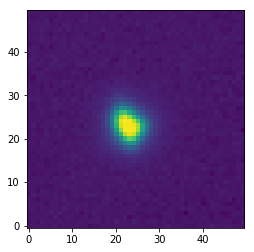

In [7]:
from astropy.visualization import SqrtStretch

from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

plt.figure()
plt.imshow(Object1_Data, norm=norm, origin='lower', cmap='viridis')


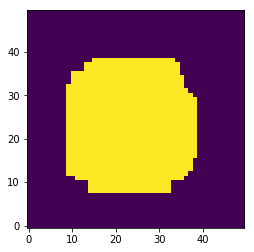

In [8]:

plt.figure()
plt.imshow(mask, origin='lower', cmap='viridis')

In [27]:
# Centroid dectection by curve fitting
# this attempt uses a bivariate normal distorbution as a model for the object

# define gaussian function, assuming no correlation between x and y
# indata is a pair of arrays, each array corresponding to the x indice or y indice, in the form (x, y)
# amplitude is the maximum amplitude of the function, minus background
# x0, y0 are the center coord. of the function
# sigma_x, sigma_y are the widths of the function
# offset is the background
# the output is flattened, in order to package it for curve_fit
def Gaussian_2d(indata , amplitude, x0, y0, sigma_x, sigma_y, offset):
    import numpy as np
    x, y = indata
    normalize = 1/(sigma_x*sigma_y*2*np.pi)
    
    gaussian_fun = offset + amplitude*normalize*np.exp(-(x-x0)**2/(2*sigma_x**2) - (y-y0)**2/(2*sigma_y**2))
    
    return gaussian_fun.ravel()

# fit data to gaussian
from scipy.optimize import curve_fit
from photutils import centroid_2dg

# generate a best guess using photutils
x_guess, y_guess = centroid_2dg(Object1_Data)
amp_guess = np.amax(Object1_Data)


# indexes of the apature, remembering that python indexes vert, horz
y = np.arange(Object1_Data.shape[0])
x = np.arange(Object1_Data.shape[1])
x, y = np.meshgrid(x, y)

# curve fit
G_fit, G_cov = curve_fit(Gaussian_2d, (x,y), Object1_Data.ravel(), p0=[amp_guess, x_guess, y_guess, 1, 1, 1])
print('Resultant parameters')
print(G_fit)

error = np.sqrt(np.diag(G_cov))
print('Error on parameters')
print(error)

print('Covariance matrix, if that is interesting')
print(G_cov)

print('peak count')
print(np.amax(Object1_Data))

Resultant parameters
[1.02834260e+06 2.27598908e+01 2.28862809e+01 2.01078174e+00
 2.23177538e+00 1.42277152e+01]
Error on parameters
[5.47623687e+03 1.04637365e-02 1.16136313e-02 1.05253526e-02
 1.16820184e-02 1.03128607e+01]
Covariance matrix, if that is interesting
[[ 2.99891703e+07  4.01006133e-07 -4.05696846e-07  2.93199724e+01
   3.25420405e+01 -1.19956603e+04]
 [ 4.01006133e-07  1.09489782e-04 -9.73417030e-15 -8.73411959e-12
   3.55590493e-13 -3.75833261e-09]
 [-4.05696846e-07 -9.73417030e-15  1.34876431e-04 -5.54939732e-13
  -1.05438437e-11  3.84104335e-09]
 [ 2.93199724e+01 -8.73411959e-12 -5.54939732e-13  1.10783048e-04
   1.43538030e-06 -1.17279496e-02]
 [ 3.25420405e+01  3.55590493e-13 -1.05438437e-11  1.43538030e-06
   1.36469555e-04 -1.30167704e-02]
 [-1.19956603e+04 -3.75833261e-09  3.84104335e-09 -1.17279496e-02
  -1.30167704e-02  1.06355096e+02]]
peak count
31364.23002421308


center:  22.759890798713858 , 22.88628091248912
width:  4.0215634883261515 by 4.463550759584808


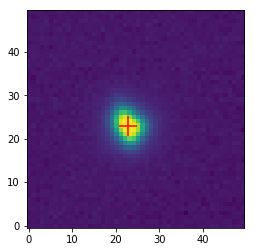

In [10]:
from astropy.visualization import SqrtStretch

from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

x_center = G_fit[1]
y_center = G_fit[2]
x_width = G_fit[3]
y_width = G_fit[4]

plt.figure()
plt.imshow(Object1_Data, norm=norm, origin='lower', cmap='viridis')
plt.errorbar(x_center, y_center, xerr=x_width, yerr=y_width, ecolor='red')

print('center: ',x_center, ',', y_center)
print('width: ', 2*x_width, 'by', 2*y_width)

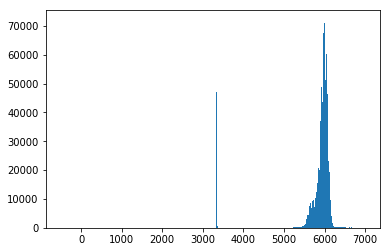

In [11]:
histogram = plt.hist(data_im1.flatten(),bins=2000, range=[-500, 7000])

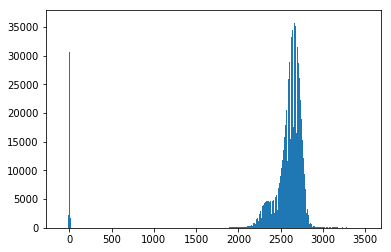

In [12]:
histogram = plt.hist(bias_subtracted_im1.flatten(),bins=2000, range=[-100,3500])

In [13]:
# find totaly count
total = np.sum(Object1_Data)

# normalize the counts: each pixel data point is now a fraction of the total power
normalized_data = np.divide(Object1_Data, total)

max_measured = total
max_fitted = G_fit[0]
print(max_measured)
print(max_fitted)
print(max_measured/max_fitted)

1063912.0605326872
1028342.5971672235
1.0345891179296152


In [14]:
# 
max_measured = total
max_fitted = G_fit[0]
print(max_measured)
print(max_fitted)
print(max_fitted/max_measured)

1063912.0605326872
1028342.5971672235
0.9665672900186368


Background mean: 2606.389093667662
Background median: 2607.376120133671
Background standerd deviation: 37.979514564431916


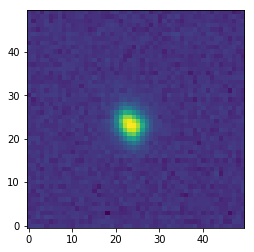

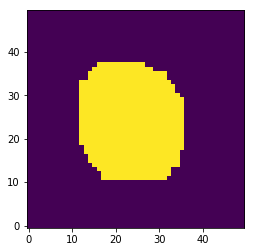

In [29]:
# Second object
# Centroid detection:
from photutils import centroid_com, centroid_1dg, centroid_2dg

# arbitrarily choosen object, section manually entered
#ymin = 840
#ymax = 890
#xmin = 1260
#xmax = 1310
ymin = 1300
ymax = 1350
xmin = 1650
xmax = 1700
Object2_Data = bias_subtracted_im1[ymin:ymax,xmin:xmax]

#Background subtract the object
Object2_Data, mask = Background_Subtract(Object2_Data)

# show the apature
from astropy.visualization import SqrtStretch

from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

plt.figure()
plt.imshow(Object2_Data, norm=norm, origin='lower', cmap='viridis')


# show the mask
plt.figure()
plt.imshow(mask, origin='lower', cmap='viridis')

Resultant parameters
[1.41582832e+05 2.32865842e+01 2.31678746e+01 1.80567753e+00
 1.93757472e+00 3.74389546e+00]
Error on parameters
[6.83338659e+02 8.56029080e-03 9.18567077e-03 8.59920977e-03
 9.22743297e-03 1.45746337e+00]
Covariance matrix, if that is interesting
[[ 4.66951722e+05 -2.95312498e-08 -3.72760417e-08  2.97762205e+00
   3.19515491e+00 -1.86780683e+02]
 [-2.95312498e-08  7.32785785e-05 -8.98891865e-15 -7.42328220e-12
  -1.97277827e-13  1.17625932e-10]
 [-3.72760417e-08 -8.98891865e-15  8.43765476e-05 -1.73176317e-13
  -7.83980594e-12  4.39617120e-10]
 [ 2.97762205e+00 -7.42328220e-12 -1.73176317e-13  7.39464087e-05
   7.16615544e-07 -1.19104901e-03]
 [ 3.19515491e+00 -1.97277827e-13 -7.83980594e-12  7.16615544e-07
   8.51455191e-05 -1.27806161e-03]
 [-1.86780683e+02  1.17625932e-10  4.39617120e-10 -1.19104901e-03
  -1.27806161e-03  2.12419946e+00]]
peak count
6193.987026466009
center:  23.286584198142215 , 23.167874556994644
width:  3.6113550560517274 by 3.87514944774667

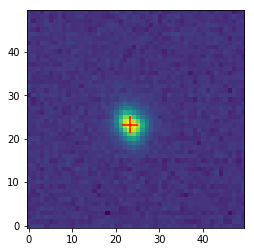

In [30]:
# Centroid dectection by curve fitting
# this attempt uses a bivariate normal distorbution as a model for the object

# define gaussian function, assuming no correlation between x and y
# indata is a pair of arrays, each array corresponding to the x indice or y indice, in the form (x, y)
# amplitude is the maximum amplitude of the function, minus background
# x0, y0 are the center coord. of the function
# sigma_x, sigma_y are the widths of the function
# offset is the background
# the output is flattened, in order to package it for curve_fit
def Gaussian_2d(indata , amplitude, x0, y0, sigma_x, sigma_y, offset):
    import numpy as np
    x, y = indata
    normalize = 1/(sigma_x*sigma_y*2*np.pi)
    
    gaussian_fun = offset + amplitude*normalize*np.exp(-(x-x0)**2/(2*sigma_x**2) - (y-y0)**2/(2*sigma_y**2))
    
    return gaussian_fun.ravel()

# fit data to gaussian
from scipy.optimize import curve_fit
from photutils import centroid_2dg

# generate a best guess using photutils
x_guess, y_guess = centroid_2dg(Object2_Data)
amp_guess = np.amax(Object2_Data)


# indexes of the apature, remembering that python indexes vert, horz
y = np.arange(Object2_Data.shape[0])
x = np.arange(Object2_Data.shape[1])
x, y = np.meshgrid(x, y)

# curve fit
G_fit, G_cov = curve_fit(Gaussian_2d, (x,y), Object2_Data.ravel(), p0=[amp_guess, x_guess, y_guess, 1, 1, 1])
print('Resultant parameters')
print(G_fit)

error = np.sqrt(np.diag(G_cov))
print('Error on parameters')
print(error)

print('Covariance matrix, if that is interesting')
print(G_cov)

print('peak count')
print(np.amax(Object2_Data))

# show the resulant center and width
from astropy.visualization import SqrtStretch

from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

x_center = G_fit[1]
y_center = G_fit[2]
x_width = G_fit[3]
y_width = G_fit[4]

plt.figure()
plt.imshow(Object2_Data, norm=norm, origin='lower', cmap='viridis')
plt.errorbar(x_center, y_center, xerr=x_width, yerr=y_width, ecolor='red')

print('center: ',x_center, ',', y_center)
print('width: ', 2*x_width, 'by', 2*y_width)

In [31]:
# find totaly count
total = np.sum(Object2_Data)

# normalize the counts: each pixel data point is now a fraction of the total power
normalized_data = np.divide(Object2_Data, total)

max_measured = total
max_fitted = G_fit[0]
print(max_measured)
print(max_fitted)
print(max_fitted/max_measured)

150942.5661650224
141582.83150854227
0.9379914169059023


Background mean: 2616.356991547061
Background median: 2616.376120133671
Background standerd deviation: 38.10540579473669


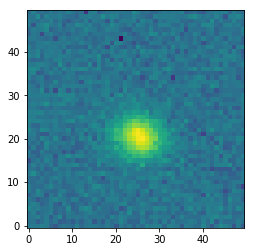

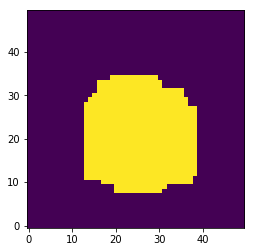

In [32]:
# Third object
# Centroid detection:
from photutils import centroid_com, centroid_1dg, centroid_2dg

# arbitrarily choosen object, section manually entered
ymin = 840
ymax = 890
xmin = 1260
xmax = 1310

Object3_Data = bias_subtracted_im1[ymin:ymax,xmin:xmax]

#Background subtract the object
Object3_Data, mask = Background_Subtract(Object3_Data)

# show the apature
from astropy.visualization import SqrtStretch

from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

plt.figure()
plt.imshow(Object3_Data, norm=norm, origin='lower', cmap='viridis')


# show the mask
plt.figure()
plt.imshow(mask, origin='lower', cmap='viridis')

Resultant parameters
[5.62073975e+04 2.52776781e+01 2.04030646e+01 3.41574330e+00
 3.06611031e+00 1.30337022e+00]
Error on parameters
[6.89250755e+02 3.96195288e-02 3.55645182e-02 4.01980747e-02
 3.60838504e-02 8.49680503e-01]
Covariance matrix, if that is interesting
[[ 4.75066603e+05  1.40269984e-07  1.99500721e-09  1.44349070e+01
   1.29575113e+01 -1.90026556e+02]
 [ 1.40269984e-07  1.56970706e-03  4.17687725e-14 -8.05522441e-11
   3.74379013e-12 -3.83504814e-10]
 [ 1.99500721e-09  4.17687725e-14  1.26483496e-03 -4.62671950e-13
  -6.22482870e-11 -7.30027193e-11]
 [ 1.44349070e+01 -8.05522441e-11 -4.62671950e-13  1.61588521e-03
   4.14518328e-05 -5.77395929e-03]
 [ 1.29575113e+01  3.74379013e-12 -6.22482870e-11  4.14518328e-05
   1.30204426e-03 -5.18300119e-03]
 [-1.90026556e+02 -3.83504814e-10 -7.30027193e-11 -5.77395929e-03
  -5.18300119e-03  7.21956957e-01]]
peak count
927.0191285866099
center:  25.277678148512642 , 20.403064648226476
width:  6.831486596348308 by 6.132220617986423

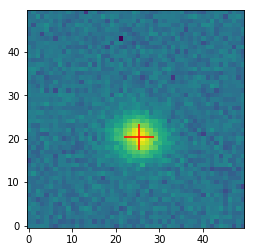

In [33]:
# Centroid dectection by curve fitting
# this attempt uses a bivariate normal distorbution as a model for the object

# define gaussian function, assuming no correlation between x and y
# indata is a pair of arrays, each array corresponding to the x indice or y indice, in the form (x, y)
# amplitude is the maximum amplitude of the function, minus background
# x0, y0 are the center coord. of the function
# sigma_x, sigma_y are the widths of the function
# offset is the background
# the output is flattened, in order to package it for curve_fit
def Gaussian_2d(indata , amplitude, x0, y0, sigma_x, sigma_y, offset):
    import numpy as np
    x, y = indata
    normalize = 1/(sigma_x*sigma_y*2*np.pi)
    
    gaussian_fun = offset + amplitude*normalize*np.exp(-(x-x0)**2/(2*sigma_x**2) - (y-y0)**2/(2*sigma_y**2))
    
    return gaussian_fun.ravel()

# fit data to gaussian
from scipy.optimize import curve_fit
from photutils import centroid_2dg

# generate a best guess using photutils
x_guess, y_guess = centroid_2dg(Object3_Data)
amp_guess = np.amax(Object3_Data)


# indexes of the apature, remembering that python indexes vert, horz
y = np.arange(Object3_Data.shape[0])
x = np.arange(Object3_Data.shape[1])
x, y = np.meshgrid(x, y)

# curve fit
G_fit, G_cov = curve_fit(Gaussian_2d, (x,y), Object3_Data.ravel(), p0=[amp_guess, x_guess, y_guess, 1, 1, 1])
print('Resultant parameters')
print(G_fit)

error = np.sqrt(np.diag(G_cov))
print('Error on parameters')
print(error)

print('Covariance matrix, if that is interesting')
print(G_cov)

print('peak count')
print(np.amax(Object3_Data))

# show the resulant center and width
from astropy.visualization import SqrtStretch

from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())

x_center = G_fit[1]
y_center = G_fit[2]
x_width = G_fit[3]
y_width = G_fit[4]

plt.figure()
plt.imshow(Object3_Data, norm=norm, origin='lower', cmap='viridis')
plt.errorbar(x_center, y_center, xerr=x_width, yerr=y_width, ecolor='red')

print('center: ',x_center, ',', y_center)
print('width: ', 2*x_width, 'by', 2*y_width)

In [36]:
# find totaly count
total = np.sum(Object3_Data)

# normalize the counts: each pixel data point is now a fraction of the total power
normalized_data = np.divide(Object3_Data, total)

max_measured = total
max_fitted = G_fit[0]
print(max_measured)
print(max_fitted)
print(max_fitted/max_measured)

59465.82146652474
56207.397516770136
0.9452050964840555
